In [4]:
import os
import json
from utils.dataset import DatasetLoader, get_tables_at_path
from utils.hypothesis import HypothesisLoader
from utils.helpers import get_datetime_str
from agents.react_agent_v2 import ReActAgentV2
from agents.coder_agent_v2 import CoderAgentV2
from tools.DockerSandbox.DockerSandboxTool import DockerSandboxTool
from tools.DockerSandbox.sandbox_core.ExecutionSandboxWrapper import EvalDataset
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage, SystemMessage, BaseMessage


__file__ = "/Users/benjamindanek/code/DSWizard/dswizard/dswizard.py"

REPO_BASE_PATH = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
LOGS_PATH = os.path.join(REPO_BASE_PATH, "logs")
BASE_DATASET_PATH = os.path.join(REPO_BASE_PATH, "benchmark_datasets/cBioPortal")
DATAHUB_PATH = os.path.join(BASE_DATASET_PATH, "datahub/public")
PLACEHOLDER_PATH = "/workdir"
model_config = os.path.join(REPO_BASE_PATH, "config/model_config.json")
api_config = os.path.join(REPO_BASE_PATH, "config/api_config.json")

BASE_PATH = os.path.dirname(os.path.abspath(__file__))
BASE_HYPOTHESIS_PATH = os.path.join(BASE_DATASET_PATH, "hypothesis")
BASE_DATASET_METADATA_PATH = os.path.join(BASE_DATASET_PATH, "dataset_metadata")

os.environ["MODEL_CONFIG"] = model_config
os.environ["API_CONFIG"] = api_config

print("base path: ", BASE_PATH)
print("repo base path: ", REPO_BASE_PATH)
print("dataset path: ", BASE_DATASET_PATH)
print("hypothesis path: ", BASE_HYPOTHESIS_PATH)
print("dataset metadata path: ", BASE_DATASET_METADATA_PATH)
print("model config: ", model_config)
print("api config: ", api_config)
    
# Create directories if they don't exist
os.makedirs(LOGS_PATH, exist_ok=True)

dataset_loader = DatasetLoader(
    dataset_metadata_directory_path=BASE_DATASET_METADATA_PATH,
)

hypothesis_loader = HypothesisLoader(
    hypothesis_directory_path=BASE_HYPOTHESIS_PATH,
)

    
def test_dataset_management():
    
    # print(dataset_loader.get_dataset("acbc_mskcc_2015"))
    
    for hypothesis_id in list(hypothesis_loader.hypothesis_data.keys())[:4]:
        hypothesis, dataset = hypothesis_loader.get_hypothesis(hypothesis_id)
        for h in hypothesis.hypotheses:
            print(h.hypothesis)
            # print(h.supporting_evidences)
            
    # hypothesis, dataset = hypothesis_loader.get_hypothesis("18772890", dataset_loader)


model_name = "gpt-4o"
study_id = 25631445
hypothesis, _ = hypothesis_loader.get_hypothesis(study_id)
dataset_ids = hypothesis.dataset_ids
dataset_id = dataset_ids[0]
dataset = dataset_loader.get_dataset(dataset_id)
table_paths = [os.path.join(os.path.join(DATAHUB_PATH, dataset.dataset_id), t.name) + ".txt" for t in dataset.tables]
query = hypothesis.hypotheses[0].hypothesis

# used in the prompt -- where do you read the tables from?
table_paths_SANDBOX = get_tables_at_path(dataset, PLACEHOLDER_PATH)

# used in the sandbox tool -- copy the tables at these locations on the local machine to the sandbox
table_paths_LOCAL = get_tables_at_path(dataset, DATAHUB_PATH)
dataset_for_sandbox = EvalDataset(
    local_table_paths=table_paths_LOCAL,
    target_table_paths=table_paths_SANDBOX
)

query = hypothesis.hypotheses[0].hypothesis

print("dataset paths: ", table_paths_LOCAL)
print("query: ", query)

base path:  /Users/benjamindanek/code/DSWizard/dswizard
repo base path:  /Users/benjamindanek/code/DSWizard
dataset path:  /Users/benjamindanek/code/DSWizard/benchmark_datasets/cBioPortal
hypothesis path:  /Users/benjamindanek/code/DSWizard/benchmark_datasets/cBioPortal/hypothesis
dataset metadata path:  /Users/benjamindanek/code/DSWizard/benchmark_datasets/cBioPortal/dataset_metadata
model config:  /Users/benjamindanek/code/DSWizard/config/model_config.json
api config:  /Users/benjamindanek/code/DSWizard/config/api_config.json


/Users/benjamindanek/code/DSWizard/dswizard/tools/DockerSandbox/sandbox_core/ExecutionSandboxWrapper.py:57: DtypeWarning: Columns (118) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(table_path, sep="\t")


dataset paths:  ['/Users/benjamindanek/code/DSWizard/benchmark_datasets/cBioPortal/datahub/public/hnsc_tcga_pub/data_mrna_seq_v2_rsem.txt', '/Users/benjamindanek/code/DSWizard/benchmark_datasets/cBioPortal/datahub/public/hnsc_tcga_pub/data_mrna_seq_v2_rsem_zscores_ref_all_samples.txt', '/Users/benjamindanek/code/DSWizard/benchmark_datasets/cBioPortal/datahub/public/hnsc_tcga_pub/data_methylation_hm450.txt', '/Users/benjamindanek/code/DSWizard/benchmark_datasets/cBioPortal/datahub/public/hnsc_tcga_pub/data_cna.txt', '/Users/benjamindanek/code/DSWizard/benchmark_datasets/cBioPortal/datahub/public/hnsc_tcga_pub/data_linear_cna.txt', '/Users/benjamindanek/code/DSWizard/benchmark_datasets/cBioPortal/datahub/public/hnsc_tcga_pub/data_clinical_sample.txt', '/Users/benjamindanek/code/DSWizard/benchmark_datasets/cBioPortal/datahub/public/hnsc_tcga_pub/data_gistic_genes_del.txt', '/Users/benjamindanek/code/DSWizard/benchmark_datasets/cBioPortal/datahub/public/hnsc_tcga_pub/data_gistic_genes_amp.

In [5]:
def print_messages(agent, messages: list[BaseMessage]):
    
    print("\n======== System Prompt ========")
    print("Message Type: ", agent.system_prompt.type)
    print(agent.system_prompt.content)
    
    for m in messages:
        print("\n======== Message ========")
        print("Message Type: ", m.type)
        
        if isinstance(m, HumanMessage):
            print("Message Content: ", m.content)
        elif isinstance(m, AIMessage):
            print("Message Content: ", m.content)
            if hasattr(m, "tool_calls"):
                for tool_call in m.tool_calls:
                    print("Tool Call ID: ", tool_call['id'])
                    print("Tool Call Name: ", tool_call['name'])
                    if tool_call['name'] == "docker_sandbox":
                        print("Tool Call Args.language: ", tool_call['args']['language'])
                        print("Tool Call Args.code: ", tool_call['args']['code'])
                    else:
                        print("Tool Call Args.query: ", tool_call['args']['query'])
        elif isinstance(m, ToolMessage):
            print("Tool Call ID: ", m.tool_call_id)
            print("Tool Call Name: ", m.name)
            print("Tool Call Status: ", m.status)
            if (m.name == "docker_sandbox"):
                content = json.loads(m.content)
                print("Tool Call Args.exit_code: \n", content['exit_code'])
                print("Tool Call Args.output: \n", content['output'])
                print("Tool Call Args.artifacts: \n", "\n".join(content['artifacts']))
                print("Tool Call Args.execution_time: \n", content['execution_time'])
            else:
                print("Message Content: ", m.content)

## Coder Agent

In [13]:
coder_agent: CoderAgentV2 = CoderAgentV2(
    model_name=model_name,
    api_config=api_config,
    language="python",
).withTools(
    tools=[
        DockerSandboxTool(
            dataset=dataset_for_sandbox,
            target_dir=os.path.join(PLACEHOLDER_PATH, dataset.dataset_id)
        )
    ]
).withDefaultSystemPrompt(
    query=query,
    dataset_paths="\n".join(table_paths_SANDBOX)
).create_agent_graph(debug=True)

SUCCESS: Execution sandbox created - id: `88236a9395857c2da5a0725e07b42af652a624d037d0cbb22309334b7c2c406a`
SUCCESS: Data successfully placed in sandbox.

======= SYSTEM PROMPT =======

# TASK
Evaluate the user's scientific hypothesis using the datasets provided. You **Must** write and execute python code to evaluate the hypothesis one time by invoking the tool docker_sandbox.

## Tips for utilizing the docker_sandbox tool: 
- To observe the output of the code execution, you must use print or logging statements. The exit code, stdout, and any generated files visible in the file system will be shared with you in the response.
- write your analysis as a part of a python function, and then invoke the tool with the function name as the argument. For example:

Here is an example that you can follow:
```python
def analyze_data(data):
    
    # your analysis code here
    
    evidence: List[str] = ...
    result: bool = ...
    
    return result, evidence

if __name__ == "__main__":
    re

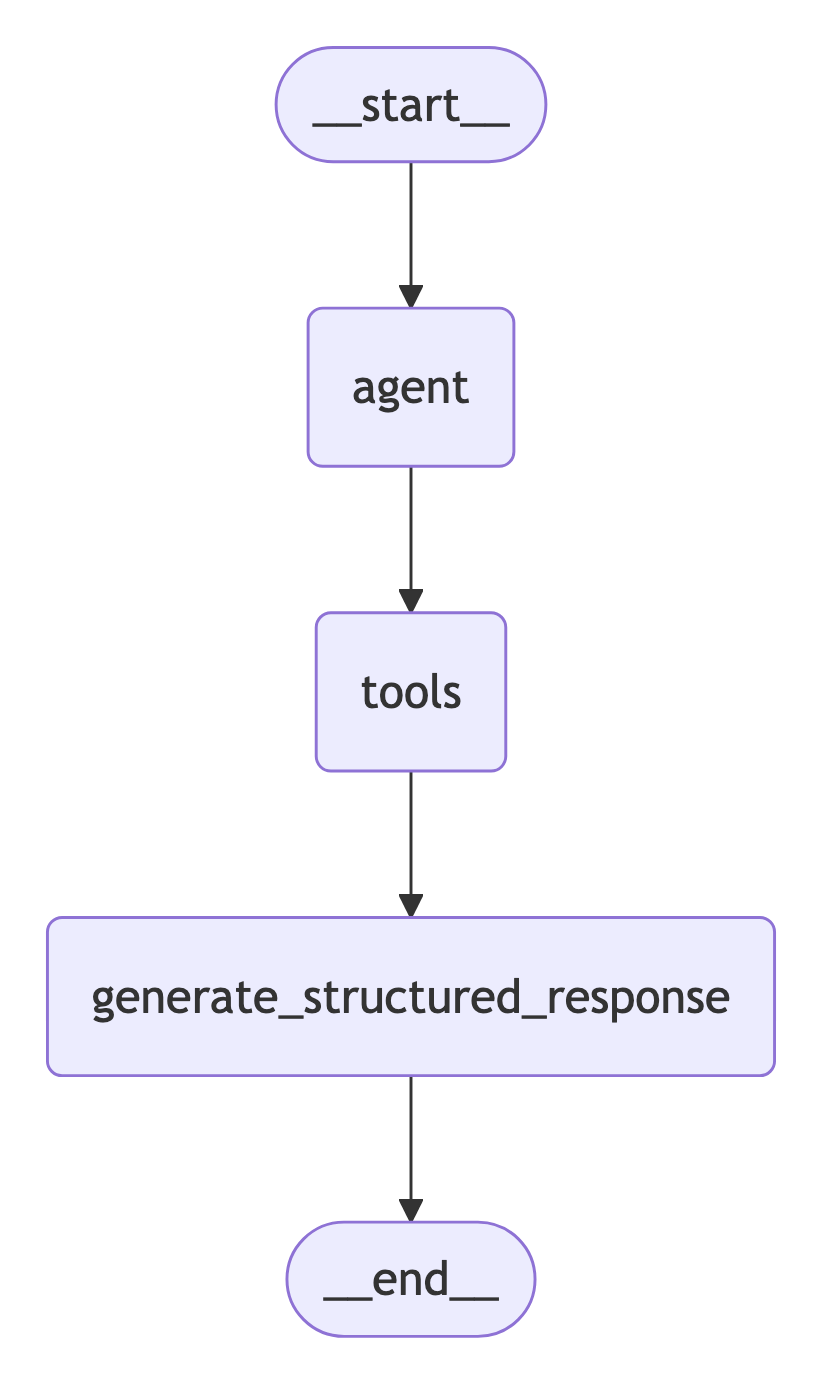

In [14]:
import nest_asyncio
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

nest_asyncio.apply()  # Required for Jupyter Notebook to run async functions

Image(
    coder_agent.agent_graph.get_graph().draw_mermaid_png(
        curve_style=CurveStyle.LINEAR,
        node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
        wrap_label_n_words=9,
        output_file_path=None,
        draw_method=MermaidDrawMethod.PYPPETEER,
        background_color="white",
        padding=10,
    )
)

In [15]:
result = coder_agent.generate(
    input_query=query
)

print(result.keys())
print(result['structured_response'])

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [('user',
               'Human-papillomavirus-associated HNSCCs have a higher frequency '
               'of PIK3CA helical domain mutations compared to '
               'non-HPV-associated HNSCCs.')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [('user',
  'Human-papillomavirus-associated HNSCCs have a higher frequency of PIK3CA '
  'helical domain mutations compared to non-HPV-associated HNSCCs.')]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='Human-papillomavirus-associated HNSCCs have a higher frequency of PIK3CA helical domain mutations compared to non-HPV-associated HNSCCs.', additional_kwargs={}, response_metadata={}, id='20122fbb-251f-46cf-8782-64db4f9a2207')]}
[1:tasks] Starting 1 task for step 1:
- agent -> AgentState(messages=[HumanMessage(content='Human-papillomavirus-associated HNSCCs have a

## ReAct Agent

In [16]:
react_agent: ReActAgentV2 = ReActAgentV2(
    model_name=model_name,
    api_config=api_config,
    language="python",
).withTools(
    tools=[
        DockerSandboxTool(
            dataset=dataset_for_sandbox,
            target_dir=os.path.join(PLACEHOLDER_PATH, dataset.dataset_id)
        )
    ]
).withDefaultSystemPrompt(
    query=query,
    dataset_paths="\n".join(table_paths_SANDBOX)
).create_agent_graph(debug=True)

SUCCESS: Execution sandbox created - id: `7e7ba65e6fd2cb28806f3c22707313933dd86e48bfddad9d8f06dc71e41ae3ff`
SUCCESS: Data successfully placed in sandbox.


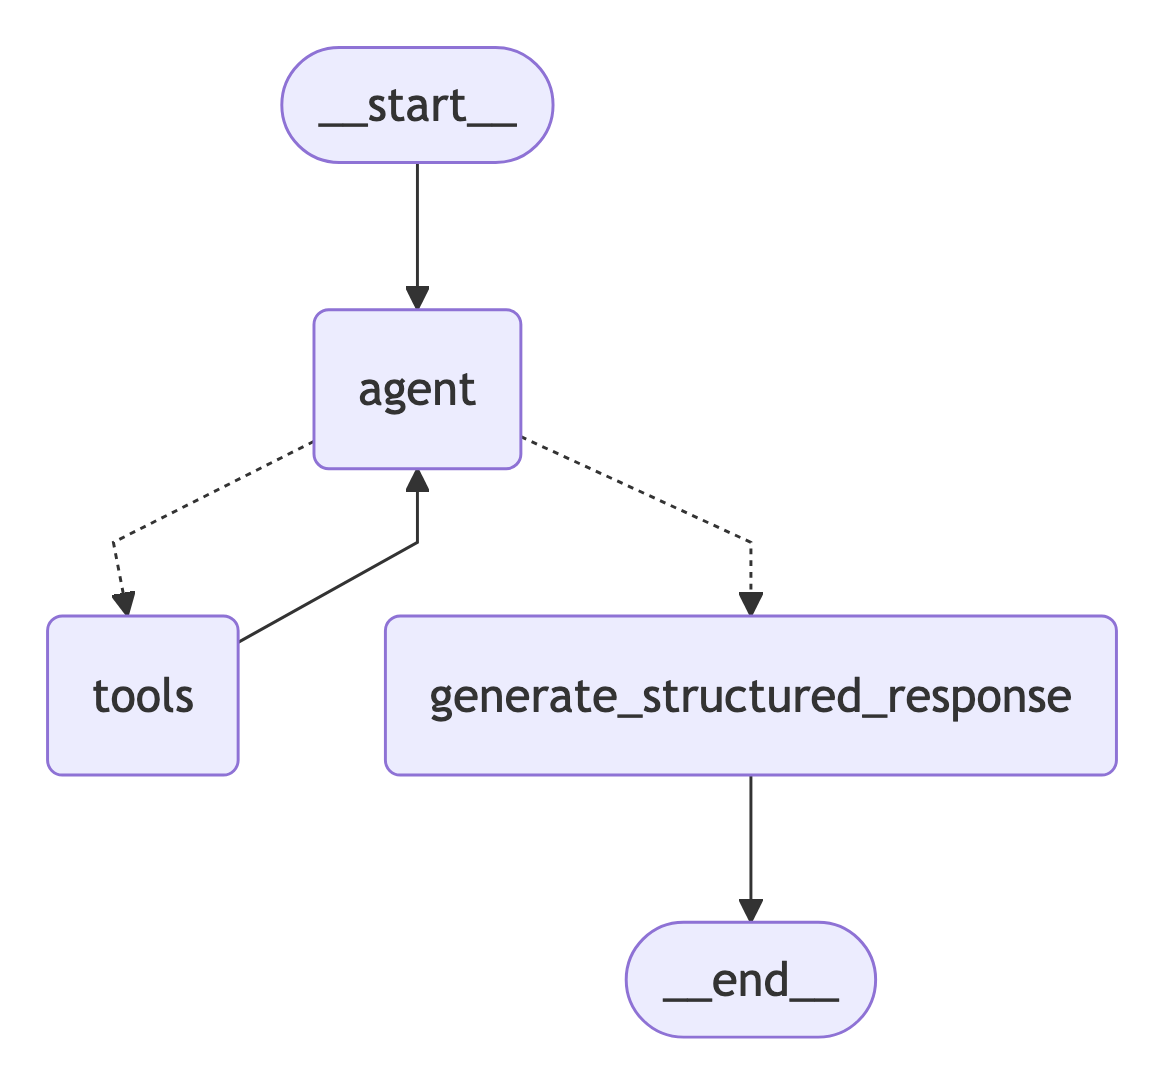

In [11]:
import nest_asyncio
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

nest_asyncio.apply()  # Required for Jupyter Notebook to run async functions

Image(
    react_agent.agent_graph.get_graph().draw_mermaid_png(
        curve_style=CurveStyle.LINEAR,
        node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
        wrap_label_n_words=9,
        output_file_path=None,
        draw_method=MermaidDrawMethod.PYPPETEER,
        background_color="white",
        padding=10,
    )
)

In [17]:
result = react_agent.generate(
    input_query=query,
    remaining_steps=5
)

print(result.keys())
print(result['structured_response'])



[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [('user',
               'Human-papillomavirus-associated HNSCCs have a higher frequency '
               'of PIK3CA helical domain mutations compared to '
               'non-HPV-associated HNSCCs.')],
 'remaining_steps': 5}
[0:writes] Finished step 0 with writes to 2 channels:
- messages -> [('user',
  'Human-papillomavirus-associated HNSCCs have a higher frequency of PIK3CA '
  'helical domain mutations compared to non-HPV-associated HNSCCs.')]
- remaining_steps -> 5
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='Human-papillomavirus-associated HNSCCs have a higher frequency of PIK3CA helical domain mutations compared to non-HPV-associated HNSCCs.', additional_kwargs={}, response_metadata={}, id='2ed258e8-f88a-4713-8cba-d6983073fe3f')],
 'remaining_steps': 5}
[1:tasks] Starting 1 task for step 1:
- agent -> AgentState(message